In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import json
from sklearn.model_selection import KFold
from tensorflow.keras.applications import ResNet50

# Bild- und Maskenpfade laden
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testbilder2/'
mask_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testmasken2/'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Funktionen zum Laden und Vorverarbeiten
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path)
    img = img.resize((256, 192))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)  # Graustufenbild
    return img

def load_and_preprocess_mask_pillow(mask_path):
    mask = Image.open(mask_path)
    mask = mask.resize((256, 192))
    mask = np.array(mask)
    mask = np.where(mask > 128, 1, 0)  # Binärmaske
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Bilder und Masken laden und vorverarbeiten
X = np.array([load_and_preprocess_image_pillow(path) for path in image_paths])
Y = np.array([load_and_preprocess_mask_pillow(path) for path in mask_paths])

# UNet-Modell mit ResNet50-Encoder
def unet_with_resnet50_encoder(input_size=(192, 256, 1)):
    inputs = Input(shape=input_size)
    
    # Konvertiere Graustufen zu 3 Kanälen, um ResNet zu unterstützen
    x = Conv2D(3, (1, 1), padding='same')(inputs)  # Ändert die Eingabe von 1-Kanal zu 3-Kanal
    
    base_model = ResNet50(weights=None, include_top=False, input_tensor=x)

    # Encoder-Schichten
    conv1 = base_model.get_layer("conv1_conv").output
    pool1 = base_model.get_layer("pool1_pool").output
    conv2 = base_model.get_layer("conv2_block3_out").output
    conv3 = base_model.get_layer("conv3_block4_out").output
    conv4 = base_model.get_layer("conv4_block6_out").output
    bottleneck = base_model.get_layer("conv5_block3_out").output

    # Decoder-Schichten
    up6 = UpSampling2D(size=(2, 2))(bottleneck)
    up6 = Conv2D(512, (2, 2), padding='same')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, (2, 2), padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, (2, 2), padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, (2, 2), padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)

    up10 = UpSampling2D(size=(2, 2))(conv9)
    conv10 = Conv2D(64, 3, activation='relu', padding='same')(up10)
    outputs = Conv2D(1, 1, activation='sigmoid')(conv10)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Loss und Metriken definieren
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - (2 * tf.reduce_sum(y_true * y_pred) + 1) / (tf.reduce_sum(y_true + y_pred) + 1)
    return bce + dice_loss

def dice_metric(y_true, y_pred):
    return (2 * tf.reduce_sum(y_true * y_pred) + 1) / (tf.reduce_sum(y_true + y_pred) + 1)

# Modellparameter
kf = KFold(n_splits=5, shuffle=True, random_state=42)
batch_size = 8
epochs = 500
best_model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_resnet.h5'
best_val_loss = float('inf')

# K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{kf.n_splits}")
    
    # Split in Trainings- und Validierungsdaten
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # Neues Modell für jeden Fold
    model = unet_with_resnet50_encoder(input_size=(192, 256, 1))
    Y_train = Y_train.astype('float32')
    Y_val = Y_val.astype('float32')
    
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=combined_loss, metrics=[dice_metric])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Training
    hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_val, Y_val), callbacks=[early_stopping, reduce_lr], verbose=1)

    # Speichern des besten Modells
    if hist.history['val_loss'][-1] < best_val_loss:
        best_val_loss = hist.history['val_loss'][-1]
        model.save(best_model_path)

# Speichern der Trainingshistorie
history_file = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history_spheroid_segmentation_unet_resnet.json'
with open(history_file, 'w') as f:
    json.dump(hist.history, f)

print(f"Bestes Modell wurde unter {best_model_path} gespeichert.")
print(f"Training Historie wurde unter {history_file} gespeichert.")



Fold 1/5
Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - dice_metric: 0.6384 - loss: 0.5547 - val_dice_metric: 0.0186 - val_loss: 1.6231 - learning_rate: 1.0000e-04
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - dice_metric: 0.8764 - loss: 0.1981 - val_dice_metric: 0.0033 - val_loss: 1.9090 - learning_rate: 1.0000e-04
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - dice_metric: 0.8947 - loss: 0.1730 - val_dice_metric: 4.9236e-04 - val_loss: 2.2139 - learning_rate: 1.0000e-04
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - dice_metric: 0.9135 - loss: 0.1458 - val_dice_metric: 0.2434 - val_loss: 1.3185 - learning_rate: 1.0000e-04
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - dice_metric: 0.9340 - loss: 0.1082 - val_dice_metric: 0.3601 - val_loss: 1.1388 - learning_rate: 1.0000e-04
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - dice_metric: 0.9357 - loss: 0.1071 - val_dice_metric: 0.8481 - val_loss: 0.2606 - learning_rate: 1.0000e-04
Ep


Fold 2/5
Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - dice_metric: 0.6326 - loss: 0.5810 - val_dice_metric: 0.0745 - val_loss: 1.3681 - learning_rate: 1.0000e-04
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - dice_metric: 0.8678 - loss: 0.2115 - val_dice_metric: 0.0029 - val_loss: 1.8303 - learning_rate: 1.0000e-04
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - dice_metric: 0.9035 - loss: 0.1560 - val_dice_metric: 0.0054 - val_loss: 1.7706 - learning_rate: 1.0000e-04
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - dice_metric: 0.9156 - loss: 0.1412 - val_dice_metric: 0.1783 - val_loss: 1.5766 - learning_rate: 1.0000e-04
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - dice_metric: 0.9337 - loss: 0.1091 - val_dice_metric: 0.6766 - val_loss: 0.5101 - learning_rate: 1.0000e-04
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - dice_metric: 0.9405 - loss: 0.0999 - val_dice_metric: 0.7469 - val_loss: 0.3862 - learning_rate: 1.0000e-04
Epoch 


Fold 3/5
Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - dice_metric: 0.6477 - loss: 0.5483 - val_dice_metric: 0.0585 - val_loss: 1.4149 - learning_rate: 1.0000e-04
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - dice_metric: 0.8537 - loss: 0.2326 - val_dice_metric: 3.7455e-04 - val_loss: 2.1989 - learning_rate: 1.0000e-04
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - dice_metric: 0.8927 - loss: 0.1771 - val_dice_metric: 0.0016 - val_loss: 2.1507 - learning_rate: 1.0000e-04
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - dice_metric: 0.9253 - loss: 0.1246 - val_dice_metric: 0.2113 - val_loss: 1.4609 - learning_rate: 1.0000e-04
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - dice_metric: 0.9293 - loss: 0.1161 - val_dice_metric: 0.6531 - val_loss: 0.5833 - learning_rate: 1.0000e-04
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - dice_metric: 0.9344 - loss: 0.1069 - val_dice_metric: 0.8552 - val_loss: 0.2434 - learning_rate: 1.0000e-04
Ep


Fold 4/5
Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - dice_metric: 0.6214 - loss: 0.6191 - val_dice_metric: 0.0294 - val_loss: 1.5100 - learning_rate: 1.0000e-04
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - dice_metric: 0.8551 - loss: 0.2281 - val_dice_metric: 0.0192 - val_loss: 1.7002 - learning_rate: 1.0000e-04
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - dice_metric: 0.9030 - loss: 0.1597 - val_dice_metric: 0.0112 - val_loss: 1.9318 - learning_rate: 1.0000e-04
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - dice_metric: 0.9112 - loss: 0.1448 - val_dice_metric: 0.0927 - val_loss: 1.6608 - learning_rate: 1.0000e-04
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - dice_metric: 0.9306 - loss: 0.1155 - val_dice_metric: 0.2046 - val_loss: 1.4182 - learning_rate: 1.0000e-04
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - dice_metric: 0.9400 - loss: 0.1007 - val_dice_metric: 0.7202 - val_loss: 0.4491 - learning_rate: 1.0000e-04
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif, Durchmesser (Pixel): 63.724312230359644, Durchmesser (µm): 120.09042990348334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_D7_ch00.tif, Durchmesser (Pixel): 62.954851205234554, Durchmesser (µm): 118.64035689261728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E7_ch00.tif, Durchmesser (Pixel): 61.198391407890085, Durchmesser (µm): 115.3302542836041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E8_ch00.tif, Durchmesser (Pixel): 65.64015373594827, Durchmesser (µm): 123.7008922526315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_F7_ch00.tif, Durchmesser (Pixel): 65.9640461892

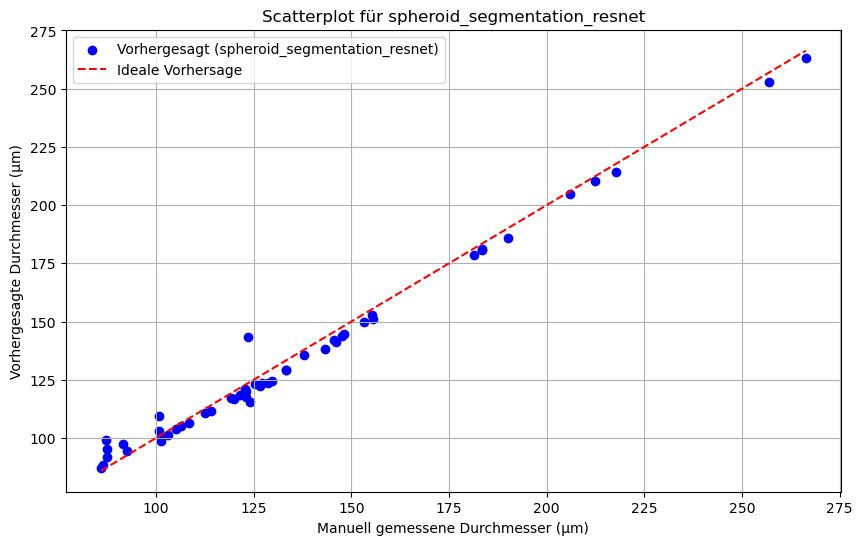

Scatterplot für spheroid_segmentation_resnet gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_resnet.png
Alle Ergebnisse und Scatterplots wurden gespeichert in C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx.
Model: spheroid_segmentation_resnet, R²: 0.9857, MAE: 3.8960


In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model



# Funktionen für Bildbearbeitung und Maskenerstellung
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

# Laden und Vorverarbeiten der Bilder
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 192))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)
    predicted_mask = model.predict(image)
    return np.squeeze(predicted_mask)

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# mit mehreren Modellen vorhersagen und die berechnungen durchführen    
def process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path):
    # Excel-Datei laden (manuelle Durchmesser)
    df_manual = pd.read_excel(excel_file_path, header=0)

    # Überprüfen, ob die 'Durchmesser'-Spalte numerische Werte enthält
    df_manual['Durchmesser'] = pd.to_numeric(df_manual['Durchmesser'], errors='coerce')
    df_manual.dropna(subset=['Durchmesser'], inplace=True)

    # Manuelle Durchmesser in eine Liste konvertieren
    manual_diameters = df_manual['Durchmesser'].tolist()

    # Skalierungsfaktoren berechnen
    scale_factor_width = 1296 / 256
    scale_factor_height = 966 / 196

    # TIFF-Dateien laden
    tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    if len(tif_files) != len(manual_diameters):
        print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
        return

    # Ergebnisse für jedes Modell speichern
    all_predicted_diameters = {}
    metrics = {}

    for model_path in model_paths:
        model_name = os.path.basename(model_path).replace('.h5', '')
        predicted_diameters = []

        # Modell laden und kompilieren (wegen dem custom loss)
        model = load_model(model_path, compile=False)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5),
                      metrics=[])

        for i, filename in enumerate(tif_files):
            img_path = os.path.join(input_dir, filename)
            try:
                # Bild laden und vorverarbeiten
                image = load_and_preprocess_image_pillow(img_path)
                predicted_mask = predict_with_model(model, image)  # Vorhersage mit dem Modell

                if predicted_mask is None:
                    print(f"Fehler bei der Vorhersage für {filename}.")
                    continue

                contours, _ = cv2.findContours((predicted_mask > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                if not contours:
                    print(f"Keine Konturen im Bild {filename} gefunden.")
                    continue

                largest_contour = max(contours, key=cv2.contourArea)
                M = cv2.moments(largest_contour)
                if M["m00"] == 0:
                    print(f"Momentenberechnung ergibt 0 für Bild {filename}.")
                    continue
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
                avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994

                # Print-Anweisung für die berechneten Durchmesser
                print(f"Bild: {filename}, Durchmesser (Pixel): {avg_diameter_pixels}, Durchmesser (µm): {avg_diameter_micrometers}")

                predicted_diameters.append(avg_diameter_micrometers)

                output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{model_name}_segmentiert.tif")
                draw_contours_and_centroid((predicted_mask > 0.5).astype(np.uint8) * 255, output_path)

            except Exception as e:
                print(f"Fehler bei der Verarbeitung von {filename}: {e}")

        all_predicted_diameters[model_name] = predicted_diameters

        # Berechnung der Metriken 
        r2 = r2_score(manual_diameters, predicted_diameters)
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        metrics[model_name] = {'R²': r2, 'MAE': mae}

        print(f"Model: {model_name}, Anzahl der vorhergesagten Durchmesser: {len(predicted_diameters)}, Werte: {predicted_diameters}")

    # Scatterplot für alle Modelle erstellen
    create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir)

    # Ergebnisse in DataFrame konvertieren und exportieren
    df_results = pd.DataFrame(all_predicted_diameters)
    df_results.insert(0, 'Manuell gemessene Durchmesser (µm)', manual_diameters)
    df_results.to_excel(output_excel_path, index=False)

    print(f"Alle Ergebnisse und Scatterplots wurden gespeichert in {output_excel_path}.")

    # Metriken ausgeben
    for model_name, metric in metrics.items():
        print(f"Model: {model_name}, R²: {metric['R²']:.4f}, MAE: {metric['MAE']:.4f}")

# Funktion zum Erstellen von Scatterplots
def create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir):
    for model_name, predicted_diameters in all_predicted_diameters.items():
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_diameters, predicted_diameters, color='blue', label=f'Vorhergesagt ({model_name})')
        plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Ideale Vorhersage')
        plt.xlabel('Manuell gemessene Durchmesser (µm)')
        plt.ylabel('Vorhergesagte Durchmesser (µm)')
        plt.title(f'Scatterplot für {model_name}')
        plt.legend()
        plt.grid(True)

        scatter_output_path = os.path.join(output_dir, f'scatter_{model_name}.png')
        plt.savefig(scatter_output_path)
        plt.show()
        plt.close()
        print(f"Scatterplot für {model_name} gespeichert unter: {scatter_output_path}")

model_paths = [

'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_resnet.h5',  
]

input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'
output_excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx'

process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path)
